tf-idf or gensim preprocess
panais topic from physicians 
dist of papers with text over pub_date
lemmatizer plural vs singular 

# Libraries

In [1]:
# Miscellaneous
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Arrays & Dataframes
import numpy as np
import pandas as pd
pd.set_option('display.max_rows',1000)

# Utilities
from covid.models.topicmodeling.ldamodel import LDAModel
from covid.models.topicmodeling.utilities.constants import COMMON_PHRASES_REGEX, COMMON_WORDS
from covid.models.topicmodeling.utilities.functions import *

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Phrases

# Sklearn
from sklearn.metrics import confusion_matrix

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
my_pal = sns.color_palette(n_colors=30)
sns.set_style('dark')
%matplotlib inline

# # Enable logging for gensim - optional
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


/Users/vasilis/Desktop/coronasucks/coronaBreakSuck2020/venv/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
# risk_factor: 391, diagnostic: 1190, treatment_and_vaccine: 722, outcome: 321

# Load Covid-Metadata and Raw Bioarxiv

In [3]:
file_path = '../data/paperclassifier/classified_merged_covid.csv'
class_cols = ['risk_factor']
bad_phrases = COMMON_PHRASES_REGEX
bad_tokens = COMMON_WORDS

df = load_paper_data(file_path, class_cols, bad_phrases, bad_tokens)

Fraction of selected papers: 391/9446


# Text Data

In [4]:
text_data = df['clean_text'].values.tolist()
meta_data = df['clean_meta'].values.tolist()

In [5]:
# Add bigrams to text data
bigram_model = Phrases(text_data, min_count=3, threshold=50) # higher threshold fewer phrases.
text_data = [bigram_model[doc] for doc in text_data]

# Train LDA

In [22]:
print("Total docs: {}".format(len(text_data)))

Total docs: 391


In [23]:
# Initialize model
lda = LDAModel(text_data, meta_data)

**1. LDA Standard gensim w/ single CPU**

In [25]:
# Choose parameters for sigle LDA
param_grid_single = {
    'num_topics': list(range(4,10,1)),
    'passes': [10],
    'random_state': [100],
    'chunksize': [5],
    'alpha': ['auto'],
    'eta': ['auto'],
    'update_every': [1]
}

# Choose scorers
scorers = ['coherence_score'] #, 'f1_score']

# Train single LDA
gs_models_single = lda.grid_search(text_data, param_grid=param_grid_single, lda_class='single', scorers=scorers)

  0%|          | 0/6 [00:09<?, ?it/s]


AttributeError: 'dict' object has no attribute 'id2token'

**2. LDA Mallet**

In [ ]:
# Choose parameters for Mallet LDA
param_grid_mallet = {
    'num_topics': list(range(4,10,1)),
    'iterations': [1500],
    'random_seed': [100],
}

gs_models_mallet = lda.grid_search(text_data, param_grid=param_grid_mallet, lda_class='mallet', scorers=scorers)

# Evaluate Models

In [ ]:
gs_models_to_df(gs_models_mallet, scorers)

TypeError: 'AxesSubplot' object is not subscriptable

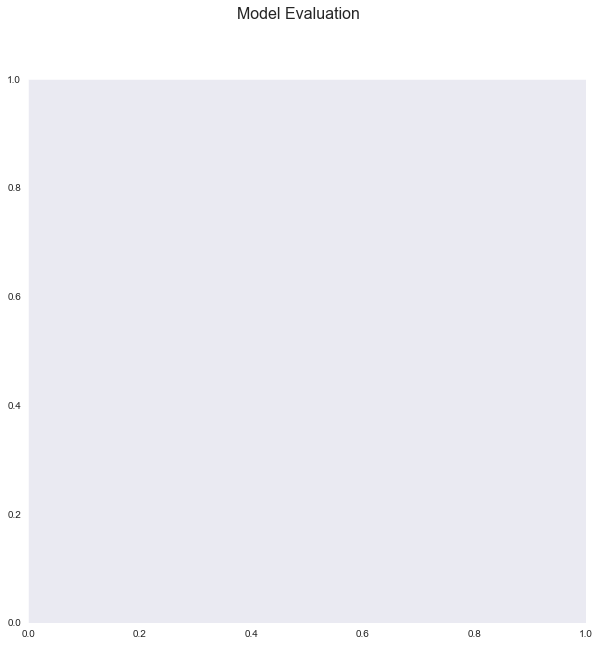

In [11]:
print_evaluation_graph_multi({'single': gs_models_single, 'mallet': gs_models_mallet}, scorers)

In [ ]:
# cf_matrix = confusion_matrix(lda.predict_topics(lda.corpus), lda.predict_topics(lda.meta_corpus))
# plt.figure(figsize=(10,7))
# sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
#              fmt='.2%', cmap='Blues');


# Best model

In [12]:
lda.create_topic_keywords_df()

topic_no,0,1,2,3,4,5,6,7
top_keywords,,,,,,,,
0,merscov,protein,patient,time,calve,infection,cell,sample
1,infection,cell,clinical,age,sample,respiratory,infection,rna
2,mers,show,symptom,estimate,age,child,sarscov,test
3,report,infect,disease,population,infection,influenza,mouse,detection
4,outbreak,rna,day,individual,herd,detect,response,assay
5,transmission,mutant,severe,disease,animal,age,human,sequence
6,exposure,bind,hospital,country,cat,year,age,strain
7,disease,antibody,treatment,confirm,day,pathogen,animal,positive
8,contact,temperature,include,day,find,patient,disease,result


In [13]:
print('Coherence Score: ', lda.coherence_score)
print('f1-score: ', lda.f1_score)

Coherence Score:  0.39545256249430855
f1-score:  0.9070578530891045


# Visualize Model

In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda.lda_model, lda.corpus, lda.id2word)
vis

/Users/vasilis/Desktop/coronasucks/coronaBreakSuck2020/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/Users/vasilis/Desktop/coronasucks/coronaBreakSuck2020/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/Users/vasilis/Desktop/coronasucks/coronaBreakSuck2020/venv/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.137196 -0.080615       1        1  34.338406
3      0.199846 -0.041511       2        1  24.275901
0     -0.266119 -0.143533       3        1  21.220225
1     -0.070922  0.265658       4        1  20.165469, topic_info=                            Term         Freq        Total Category  logprob  \
360                     patients  5469.000000  5469.000000  Default  30.0000   
1531                       calve  1505.000000  1505.000000  Default  29.0000   
471                      sarscov  1096.000000  1096.000000  Default  28.0000   
6059                     merscov  2081.000000  2081.000000  Default  27.0000   
62                      children  1534.000000  1534.000000  Default  26.0000   
688                        cells  1573.000000  1573.000000  Default  25.0000   
233                    infection  4103.000000  4103.000000  Default  24.0000   
470                       sample  2901.000000  2901.000000  Default  23.0000   
455                          rna   924.000000   924.000000  Default  22.0000   
444                  respiratory  2340.000000  2340.000000  Default  21.0000   
1322                        sars  1008.000000  1008.000000  Default  20.0000   
1224                     protein  1064.000000  1064.000000  Default  19.0000   
484                     sequence   714.000000   714.000000  Default  18.0000   
2467                        mice   560.000000   560.000000  Default  17.0000   
33                         assay   799.000000   799.000000  Default  16.0000   
879                   expression   535.000000   535.000000  Default  15.0000   
1612                        herd   608.000000   608.000000  Default  14.0000   
6990                        mers   758.000000   758.000000  Default  13.0000   
12                           age  2967.000000  2967.000000  Default  12.0000   
65                      clinical  1487.000000  1487.000000  Default  11.0000   
136                      disease  2439.000000  2439.000000  Default  10.0000   
5444                         dog   482.000000   482.000000  Default   9.0000   
439                       report  2318.000000  2318.000000  Default   8.0000   
235                    influenza  1095.000000  1095.000000  Default   7.0000   
490                       severe  1102.000000  1102.000000  Default   6.0000   
2120                transmission   797.000000   797.000000  Default   5.0000   
1445                   treatment   834.000000   834.000000  Default   4.0000   
2622                    response   505.000000   505.000000  Default   3.0000   
1842                     contact   718.000000   718.000000  Default   2.0000   
209                        human  1070.000000  1070.000000  Default   1.0000   
15946                 rise_titer    18.472937    18.472937   Topic1  -9.0397   
6033                         eye    20.646224    20.646224   Topic1  -8.9285   
3461     require_hospitalization    29.339371    29.339371   Topic1  -8.5771   
9521                  accessible    18.472937    18.472937   Topic1  -9.0397   
1983                      myotis    11.953077    11.953077   Topic1  -9.4750   
4149                    eventual    11.953077    11.953077   Topic1  -9.4750   
17508                 parametric    18.472937    18.472937   Topic1  -9.0397   
7018                       proxy    20.646224    20.646224   Topic1  -8.9285   
4185                   household   131.483847   131.483847   Topic1  -7.0771   
7853                      senior    11.953077    11.953077   Topic1  -9.4750   
5866                  manuscript    47.812308    47.812308   Topic1  -8.0887   
2024            phylogenetically    11.953077    11.953077   Topic1  -9.4750   
2041               prospectively    20.646224    20.646224   Topic1  -8.9285   
4222             metapneumovirus    23.906154    23.906154   Topic1  -8.7819   
2050                   realistic 

# Top Topic Per Doc

In [15]:
df_top_topic_per_doc = lda.create_top_topic_per_doc_df(lda.corpus)

In [16]:
df_top_topic_per_doc.head(5)

,dominant_topic,topic_probability,topic_keywords
corpus_id,,,
0,2,0.6748,"respiratory, merscov, infection, children, age..."
1,0,0.8675,"sample, rna, result, sequence, assay, detect, ..."
2,3,0.7759,"patients, calve, disease, find, clinical, days..."
3,2,0.5741,"respiratory, merscov, infection, children, age..."
4,1,0.8543,"infection, sarscov, cells, sars, age, disease,..."


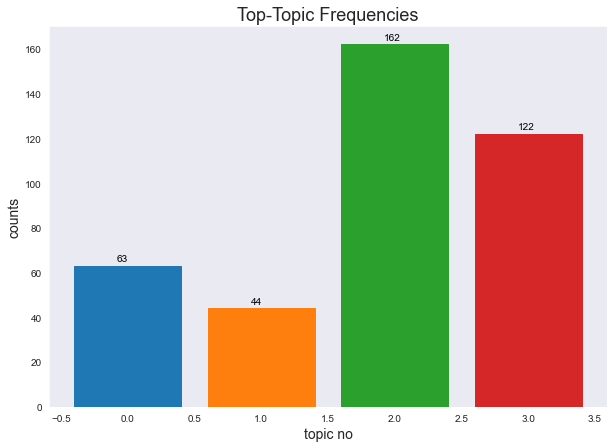

In [17]:
print_topic_freq(df_top_topic_per_doc)

# Find the most representative document for each topic

In [18]:
topic_to_rep_id = lda.find_topic_to_rep_id()
for topic_no, corpus_id in topic_to_rep_id.items():
    kws = ", ".join(lda.get_topic_keywords(topic_no))
    rep = df.loc[corpus_id, 'meta']
    print(f"\nTopic {topic_no}\n" + 
          "-"*10 + "\n" +
          f"keywords: {kws}\n\n" + 
          f"meta:\n\n{rep}\n")


Topic 0
----------
keywords: sample, rna, result, sequence, assay, detect, test, protein, show, detection

meta:

Rotavirus y otros virus productores de gastroenteritis aguda en la infancia La gastroenteritis aguda es una de las enfermedades más comunes y que afecta a los niños de todo el mundo. Los virus se reconocen hoy día como una de las principales causas de esta infección, particularmente en la infancia. Desde que se describiera el virus Norwalk por primera vez como causa de gastroenteritis, se ha ido incrementando progresivamente el número de virus asociados a esta enfermedad. Los rotavirus son la primera causa de diarrea grave en niños menores de 5 años y los astrovirus, calicivirus y adenovirus entéricos son también agentes etiológicos importantes de la enfermedad. Otros virus, como los torovirus, coronavirus, picobirnaviruses, virus Aichi o los bocavirus humanos, también se han implicado en la etiología de la diarrea aguda. La vacunación frente a los rotavirus constituye, ho

# Save Results

In [ ]:
# DATA_DIR = '../data/vasilis/lda/'
# lda.lda_model.save(DATA_DIR + 'lda_model')

In [ ]:
# import pickle

# with open(DATA_DIR + 'lda.pickle', 'wb') as handle:
#     pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

